In [ ]:
%%capture
!wget "https://github.com/aaravindravi/Brain-computer-interfaces/archive/refs/heads/master.zip"

In [ ]:
%%capture
!sudo apt-get install unzip
!unzip "/content/master.zip"

In [ ]:
import sys
import os
sys.path.insert(0, os.path.abspath('/content/Brain-computer-interfaces-master'))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
import time

import warnings
import numpy as np
import numpy.matlib as npm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn.model_selection import KFold

from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from keras.losses import categorical_crossentropy

from scripts import ssvep_utils as su
warnings.filterwarnings('ignore')

In [ ]:
def get_training_data(features_data):
    features_data = np.reshape(features_data, (features_data.shape[0], features_data.shape[1], 
                                               features_data.shape[2], 
                                               features_data.shape[3]*features_data.shape[4]))
    train_data = features_data[:, :, 0, :].T
    for target in range(1, features_data.shape[2]):
        train_data = np.vstack([train_data, np.squeeze(features_data[:, :, target, :]).T])

    train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 
                                         train_data.shape[2], 1))
    total_epochs_per_class = features_data.shape[3]
    features_data = []
    class_labels = np.arange(CNN_PARAMS['num_classes'])
    labels = (npm.repmat(class_labels, total_epochs_per_class, 1).T).ravel()
    labels = to_categorical(labels)
    
    return train_data, labels

In [ ]:
def train_CNN_cross_val_predict(train_data, labels, num_folds=10):
    kf = KFold(n_splits=num_folds, shuffle=True)
    kf.get_n_splits(train_data)
    cv_acc = np.zeros((num_folds, 1))
    fold = -1

    for train_index, test_index in kf.split(train_data):

        x_tr, x_ts = train_data[train_index], train_data[test_index]
        y_tr, y_ts = labels[train_index], labels[test_index]
        input_shape = np.array([x_tr.shape[1], x_tr.shape[2], x_tr.shape[3]])
        
        fold = fold + 1
        
        model = su.CNN_model(input_shape, CNN_PARAMS)
        
        sgd = optimizers.SGD(lr=CNN_PARAMS['learning_rate'], decay=CNN_PARAMS['lr_decay'], 
                             momentum=CNN_PARAMS['momentum'], nesterov=False)
        model.compile(loss=categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])
        history = model.fit(x_tr, y_tr, batch_size=CNN_PARAMS['batch_size'], 
                            epochs=CNN_PARAMS['epochs'], verbose=0)

        score = model.evaluate(x_ts, y_ts, verbose=0) 
        cv_acc[fold, :] = score[1]*100
        print(f'cv{fold+1}:{score[1]*100:.2f}%', end=" ")
    
    return cv_acc

In [ ]:
def train_CNN_block(train_data, train_labels, test_data, test_labels):
    x_tr, x_ts = train_data, test_data
    y_tr, y_ts = train_labels, test_labels
    input_shape = np.array([x_tr.shape[1], x_tr.shape[2], x_tr.shape[3]])
    model = su.CNN_model(input_shape, CNN_PARAMS)
    sgd = optimizers.SGD(lr=CNN_PARAMS['learning_rate'], decay=CNN_PARAMS['lr_decay'], 
                             momentum=CNN_PARAMS['momentum'], nesterov=False)
    model.compile(loss=categorical_crossentropy, optimizer=sgd, metrics=["accuracy"])
    history = model.fit(x_tr, y_tr, batch_size=CNN_PARAMS['batch_size'], 
                        epochs=CNN_PARAMS['epochs'], verbose=0)

    score = model.evaluate(x_ts, y_ts, verbose=0) 
    cv_acc = score[1]*100

    score_tr = model.evaluate(x_tr, y_tr, verbose = 0)
    tr_acc = score[1]*100

    return cv_acc, tr_acc

In [ ]:
data_path = os.path.abspath('/content/drive/MyDrive/Work/Ahmadi roshan/Pilot 3/')

CNN_PARAMS = {
    'batch_size': 32,
    'epochs': 100,
    'droprate': 0.5,
    'learning_rate': 0.001,
    'lr_decay': 0.0,
    'l2_lambda': 0.0001,
    'momentum': 0.9,
    'kernel_f': 10,
    'n_ch': 10,
    'num_classes': 5}

FFT_PARAMS = {
    'resolution': 0.2930,
    'start_frequency': 3.0,
    'end_frequency': 35.0,
    'sampling_rate': 512
}

window_len = 3
shift_len = 1
    
all_acc = np.zeros((10, 1))

magnitude_spectrum_features = dict()
complex_spectrum_features = dict()

In [ ]:
mcnn_training_data = dict()
ccnn_training_data = dict()

In [ ]:
mcnn_results = dict()
ccnn_results = dict()

In [ ]:
all_segmented_data = dict()
for subject in range(6, 7):
    dataset = sio.loadmat(f'{data_path}/S0{subject+1}.mat')
    eeg = np.array(dataset['eeg'], dtype='float32')
    print(eeg.shape)
    CNN_PARAMS['num_classes'] = eeg.shape[0]
    CNN_PARAMS['n_ch'] = eeg.shape[1]
    total_trial_len = eeg.shape[2]
    num_trials = eeg.shape[3]
    sample_rate = 512

    filtered_data = su.get_filtered_eeg(eeg, 4, 45, 4, sample_rate)
    print(filtered_data.shape)
    all_segmented_data[f's{subject+1}'] = su.get_segmented_epochs(filtered_data, window_len, 
                                                                  shift_len, sample_rate)
    

(5, 10, 2560, 20)
(5, 10, 2047, 20)


In [ ]:
print(filtered_data.shape)

(5, 10, 2047, 20)


In [ ]:
print(all_segmented_data['s7'].shape)

(5, 10, 20, 2, 1536)


In [ ]:
for subject in all_segmented_data.keys():
    magnitude_spectrum_features[subject] = su.magnitude_spectrum_features(all_segmented_data[subject], 
                                                                          FFT_PARAMS)
      

    complex_spectrum_features[subject] = su.complex_spectrum_features(all_segmented_data[subject], 
                                                                      FFT_PARAMS)

In [ ]:
print(complex_spectrum_features['s7'].shape)

(220, 10, 5, 20, 2)


## Testing for block 19 and 20

In [ ]:
for subject in all_segmented_data.keys():
  train_part_of_data = magnitude_spectrum_features[subject][:,:,:,:18,:]
  test_part_of_data = magnitude_spectrum_features[subject][:,:,:,18:,:]

In [ ]:
CNN_PARAMS['epochs'] = 200

In [ ]:
start_e = time.time()
train_data, train_labels = get_training_data(train_part_of_data)
test_data, test_labels = get_training_data(test_part_of_data)
test_acc, tr_acc = train_CNN_block(train_data, train_labels, test_data, test_labels)
end_e = time.time()
print("train accuracy in M-CNN is: ", tr_acc)
print("the final acc in M-CNN is: ", test_acc)
print("elapsed time: ", end_e-start_e)

train accuracy in M-CNN is:  100.0
the final acc in M-CNN is:  100.0
elapsed time:  17.54795002937317


In [ ]:
for subject in all_segmented_data.keys():
  train_part_of_data = complex_spectrum_features[subject][:,:,:,:18,:]
  test_part_of_data = complex_spectrum_features[subject][:,:,:,18:,:]

In [ ]:
start_e = time.time()
train_data, train_labels = get_training_data(train_part_of_data)
test_data, test_labels = get_training_data(test_part_of_data)
acc = train_CNN_block(train_data, train_labels, test_data, test_labels)
end_e = time.time()
print("the final acc in C-CNN is: ", acc)
print("elapsed time: ", end_e-start_e)

the final acc in C-CNN is:  (100.0, 100.0)
elapsed time:  31.533177375793457


## Block based Kfold cross validation

In [ ]:
CNN_PARAMS['epochs'] = 100

In [ ]:
for subject in all_segmented_data.keys():
  tests = range(0, 20, 2)
  accuracies = []
  for ind, test in enumerate(tests):
    train_ind = [i for i in range(20) if i != test and i != test+1]
    test_ind = [i for i in range(20) if i == test or i == test+1]
    train_part_of_data =  magnitude_spectrum_features[subject][:,:,:,train_ind,:]
    test_part_of_data = magnitude_spectrum_features[subject][:,:,:,test_ind,:]
    train_data, train_labels = get_training_data(train_part_of_data)
    test_data, test_labels = get_training_data(test_part_of_data)
    acc = train_CNN_block(train_data, train_labels, test_data, test_labels)
    print("train accuracy for set ", ind+1, ":", acc[1])
    print("test accuracy for set ", ind+1, ":", acc[0])
    print('-'*10)
    accuracies.append(acc[0])
print("final accuracy is :", np.mean(np.array(accuracies)))

train accuracy for set  1 : 100.0
test accuracy for set  1 : 100.0
----------
train accuracy for set  2 : 100.0
test accuracy for set  2 : 100.0
----------
train accuracy for set  3 : 100.0
test accuracy for set  3 : 100.0
----------
train accuracy for set  4 : 89.99999761581421
test accuracy for set  4 : 89.99999761581421
----------
train accuracy for set  5 : 89.99999761581421
test accuracy for set  5 : 89.99999761581421
----------
train accuracy for set  6 : 100.0
test accuracy for set  6 : 100.0
----------
train accuracy for set  7 : 100.0
test accuracy for set  7 : 100.0
----------
train accuracy for set  8 : 100.0
test accuracy for set  8 : 100.0
----------
train accuracy for set  9 : 94.9999988079071
test accuracy for set  9 : 94.9999988079071
----------
train accuracy for set  10 : 100.0
test accuracy for set  10 : 100.0
----------
final accuracy is : 97.49999940395355


In [ ]:
for subject in all_segmented_data.keys():
  tests = range(0, 20, 2)
  accuracies = []
  for ind, test in enumerate(tests):
    train_ind = [i for i in range(20) if i != test and i != test+1]
    test_ind = [i for i in range(20) if i == test or i == test+1]
    train_part_of_data =  complex_spectrum_features[subject][:,:,:,train_ind,:]
    test_part_of_data = complex_spectrum_features[subject][:,:,:,test_ind,:]
    train_data, train_labels = get_training_data(train_part_of_data)
    test_data, test_labels = get_training_data(test_part_of_data)
    acc = train_CNN_block(train_data, train_labels, test_data, test_labels)
    # print("train accuracy for set ", ind+1, ":", acc[1])
    print("test accuracy for set ", ind+1, ":", acc[0])
    print('-'*10)
    accuracies.append(acc[0])
print("final accuracy is :", np.mean(np.array(accuracies)))

test accuracy for set  1 : 89.99999761581421
----------
test accuracy for set  2 : 100.0
----------
test accuracy for set  3 : 94.9999988079071
----------
test accuracy for set  4 : 100.0
----------
test accuracy for set  5 : 100.0
----------
test accuracy for set  6 : 100.0
----------
test accuracy for set  7 : 85.00000238418579
----------
test accuracy for set  8 : 100.0
----------
test accuracy for set  9 : 100.0
----------
test accuracy for set  10 : 100.0
----------
final accuracy is : 96.99999988079071


## KFold cross validation

In [ ]:
for subject in all_segmented_data.keys():
    mcnn_training_data[subject] = dict()
    ccnn_training_data[subject] = dict()
    train_data, labels = get_training_data(magnitude_spectrum_features[subject])
    mcnn_training_data[subject]['train_data'] = train_data
    mcnn_training_data[subject]['label'] = labels
    
    train_data, labels = get_training_data(complex_spectrum_features[subject])
    ccnn_training_data[subject]['train_data'] = train_data
    ccnn_training_data[subject]['label'] = labels

In [ ]:
print(ccnn_training_data['s7']['train_data'].shape)

(200, 10, 220, 1)


In [ ]:
start_e = time.time()

for subject in mcnn_training_data.keys():
    print(f'\nMCNN - Subject: {subject}')
    print("shape: ", mcnn_training_data[subject]['train_data'].shape)
    train_data = mcnn_training_data[subject]['train_data']
    labels = mcnn_training_data[subject]['label']
    
    cv_acc = train_CNN_cross_val_predict(train_data, labels, 10)
    mcnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {mcnn_results[subject]:2f}%')

mcnn_overall_accuracy = np.mean(np.fromiter(mcnn_results.values(), dtype=float))    
print(f'Overall Accuracy MCNN - {mcnn_overall_accuracy:.2f}%')
end_e = time.time()

elapsed_time = end_e - start_e
print('Execution time:', elapsed_time, 'seconds')


MCNN - Subject: s7
shape:  (200, 10, 110, 1)
cv1:100.00% cv2:95.00% cv3:100.00% cv4:100.00% cv5:100.00% cv6:100.00% cv7:100.00% cv8:100.00% cv9:95.00% cv10:100.00% 
Accuracy: 99.000000%
Overall Accuracy MCNN - 99.00%
Execution time: 131.29001712799072 seconds


In [ ]:
CNN_PARAMS['epochs'] = 150
start_e = time.time()

for subject in ccnn_training_data.keys():
    print(f'\nCCNN - Subject: {subject}')
    train_data = ccnn_training_data[subject]['train_data']
    labels = ccnn_training_data[subject]['label']
    
    cv_acc = train_CNN_cross_val_predict(train_data, labels, 10)
    ccnn_results[subject] = np.mean(cv_acc)
    print(f'\nAccuracy: {ccnn_results[subject]:.2f}%')

ccnn_overall_accuracy = np.mean(np.fromiter(ccnn_results.values(), dtype=float))    
print(f'Overall Accuracy CCNN - {ccnn_overall_accuracy:.2f}%')
end_e = time.time()

elapsed_time = end_e - start_e
print('Execution time:', elapsed_time, 'seconds')


CCNN - Subject: s7
cv1:100.00% cv2:100.00% cv3:100.00% cv4:100.00% cv5:100.00% cv6:100.00% cv7:95.00% cv8:100.00% cv9:100.00% cv10:100.00% 
Accuracy: 99.50%
Overall Accuracy CCNN - 99.50%
Execution time: 227.90851974487305 seconds


In [ ]:
results = pd.DataFrame({'mcnn': np.fromiter(mcnn_results.values(), dtype=float), 
              'ccnn': np.fromiter(ccnn_results.values(), dtype=float)})

In [ ]:
print(results)

        mcnn       ccnn
0  94.999999  94.999999


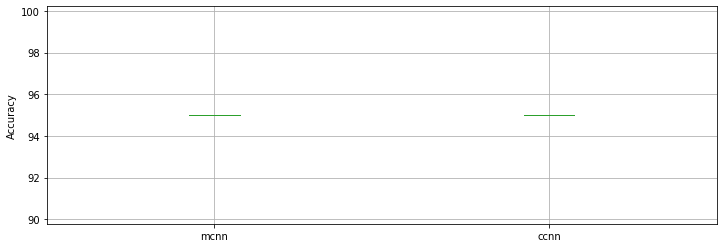

In [ ]:
results.boxplot(figsize=(12, 4), column=['mcnn', 'ccnn'])
plt.ylabel('Accuracy')
plt.show()

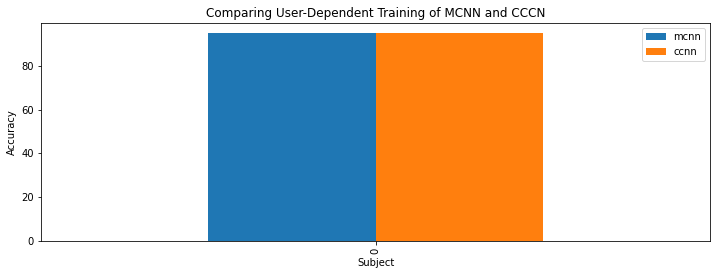

In [ ]:
results.plot.bar(figsize=(12, 4), title='Comparing User-Dependent Training of MCNN and CCCN')
plt.xlabel('Subject')
plt.ylabel('Accuracy')
plt.show()